In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV


In [2]:
# Load data
data = pd.read_csv("palay_quarterly.csv")

# Map quarters to the first month of each quarter and create datetime index
month_map = {1: '01', 2: '04', 3: '07', 4: '10'}
data['Month'] = data['Quarter'].map(month_map)
data['date'] = pd.to_datetime(data['Year'].astype(str) + '-' + data['Month'])
data.set_index('date', inplace=True)

# Optionally drop extra columns
data = data[['Palay']]  # Assuming 'Palay' is the column to forecast
print(data.head())

            Palay
date             
1987-01-01  12340
1987-04-01   3050
1987-07-01   5569
1987-10-01  10485
1988-01-01   6644


In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(data['Palay'], model='additive', period=12)
data['seasonal'] = decomposition.seasonal

# Generate lag features for improved forecasting
for i in range(1, 13):
    data[f'lag_{i}'] = data['Palay'].shift(i)
data.dropna(inplace=True)


In [4]:
split_date = '2010-12-31'
train = data[:split_date]
test = data[split_date:]


In [5]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Grid search to find the best model parameters
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=123),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error'
)
grid_search.fit(train.drop(columns='Palay'), train['Palay'])
best_forest = grid_search.best_estimator_


In [6]:
predictions = best_forest.predict(test.drop(columns='Palay'))


In [18]:
# Ensure that predictions are trimmed to match the test set length
# Use the minimum length between predictions and test to avoid broadcasting issues
min_len = min(len(test), len(predictions))

# Trim predictions if necessary
predictions = predictions[:min_len]
test = test.iloc[:min_len]  # Ensure the test set also matches the length of predictions

# Calculate residuals from the initial predictions
initial_residuals = test['Palay'] - predictions

# Prepare data for the linear model (use shifted residuals as features)
test.loc[:, 'initial_residuals'] = initial_residuals.shift()  # Use .loc to avoid SettingWithCopyWarning
test.dropna(inplace=True)  # Drop any NaN values generated by shifting

# Train the linear model to predict residuals
residual_model = RandomForestRegressor(n_estimators=100, random_state=123)
residual_model.fit(test[['initial_residuals']], initial_residuals.loc[test.index])

# Predict residuals using the linear model
predicted_residuals = residual_model.predict(test[['initial_residuals']])


In [19]:
# Ensure that predictions and predicted_residuals have the same length as test set
min_len = min(len(predictions), len(test.index), len(predicted_residuals))

# Trim predictions and residuals to match the test set's length
predictions_series = pd.Series(predictions[:min_len], index=test.index[:min_len])  # Trim predictions
predicted_residuals_series = pd.Series(predicted_residuals[:min_len], index=test.index[:min_len])  # Trim residuals

# Adjust the initial predictions by adding the predicted residuals
adjusted_predictions = predictions_series + predicted_residuals_series

# Recalculate metrics using the properly aligned indices
adjusted_mse = mean_squared_error(test['Palay'].iloc[:min_len], adjusted_predictions)
print(f'Adjusted MSE: {adjusted_mse}')


Adjusted MSE: 13127069.187328735


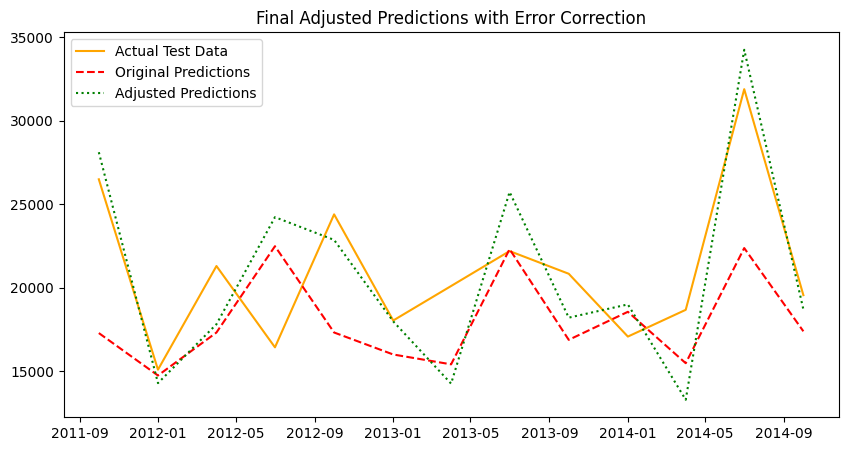

In [20]:
# Plotting the original and adjusted predictions for confirmation
plt.figure(figsize=(10, 5))
plt.plot(test['Palay'], label='Actual Test Data', color='orange')
plt.plot(predictions_series, label='Original Predictions', linestyle='--', color='red')
plt.plot(adjusted_predictions, label='Adjusted Predictions', linestyle=':', color='green')
plt.title('Final Adjusted Predictions with Error Correction')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate MAE and R-squared for adjusted predictions
adjusted_mae = mean_absolute_error(test['Palay'], adjusted_predictions)
adjusted_r2 = r2_score(test['Palay'], adjusted_predictions)

print(f'Adjusted MAE: {adjusted_mae}')
print(f'Adjusted R-squared: {adjusted_r2}')


Adjusted MAE: 2905.872309355158
Adjusted R-squared: 0.3154302564431227
